In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_curve, auc
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline

import os

#file_path = r".\4tone_cell\4T1006.mat"
file_path = r"Z:\projects\trial_classification\4tone_cell\4T1002.mat"

file = h5py.File(file_path, 'r')
filename = os.path.basename(file.filename)
print("Keys in file:", list(file.keys()))

ffr_nodss = file["ffr_nodss"][:]  
labels_ref = file["labels"][:]
t = file["time"][:].flatten()

labels = np.array([
    int(file[ref][()].tobytes().decode('ascii').strip('\x00'))
    for ref in labels_ref[0]
])


Keys in file: ['#refs#', 'ffr_dss', 'ffr_nodss', 'labels', 'time']


In [2]:
xmin, xmax = 50, 250

xmin_ind = np.argmin(np.abs(t - xmin))   # index (integer)
xmax_ind = np.argmin(np.abs(t - xmax))   # index (integer)

ffr_trimmed = ffr_nodss[:, xmin_ind:xmax_ind]
t_trimmed = t[xmin_ind:xmax_ind]

print(f"Trimmed shape: {ffr_trimmed.shape}, Time range: {t_trimmed[0]} – {t_trimmed[-1]}")


df = pd.DataFrame(ffr_trimmed)
df['label'] = labels
df.columns = [f't{t_i}' for t_i in range(ffr_trimmed.shape[1])] + ['label']

group_size = 5
num_groups = len(df) // group_size

X_avg = np.array([
    df.iloc[i*group_size:(i+1)*group_size, :-1].mean(axis=0).values
    for i in range(num_groups)
])
y_avg = np.array([
    df.iloc[i*group_size:(i+1)*group_size]['label'].mode()[0]
    for i in range(num_groups)
])

print("After averaging:", X_avg.shape, y_avg.shape)



Trimmed shape: (4086, 3277), Time range: 49.98779296875 – 249.93896484375
After averaging: (817, 3277) (817,)


In [3]:

lda_pipeline = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lda_pipeline, X_avg, y_avg, cv=kf)
print(f"\nCross-validation accuracies: {scores}")
print(f"Mean CV Accuracy: {np.mean(scores):.3f}")

lda_pipeline.fit(X_avg, y_avg)
y_pred = lda_pipeline.predict(X_avg)

print("\nClassification Report:\n", classification_report(y_avg, y_pred))
print("Macro F1-score:", f1_score(y_avg, y_pred, average='macro'))





Cross-validation accuracies: [0.65853659 0.78658537 0.71779141 0.6993865  0.74846626]
Mean CV Accuracy: 0.722

Classification Report:
               precision    recall  f1-score   support

           1       0.98      0.98      0.98       231
           2       0.98      0.99      0.99       210
           3       0.99      0.99      0.99       189
           4       0.99      0.98      0.99       187

    accuracy                           0.99       817
   macro avg       0.99      0.99      0.99       817
weighted avg       0.99      0.99      0.99       817

Macro F1-score: 0.986782818612814



Confusion Matrix (50Trial):
 [[227   3   0   1]
 [  0 208   2   0]
 [  2   0 187   0]
 [  2   1   0 184]]


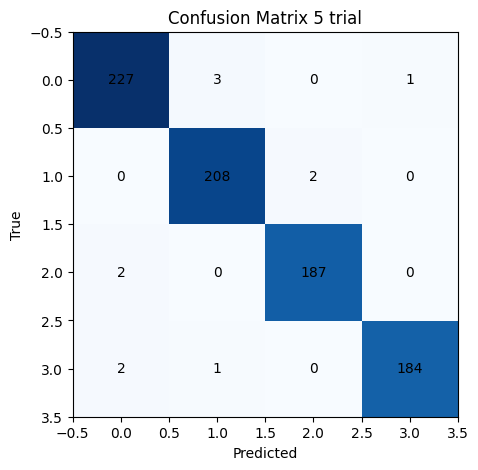

In [4]:
cm = confusion_matrix(y_avg, y_pred)
print("\nConfusion Matrix (50Trial):\n", cm)

plt.figure(figsize=(5,5))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix 5 trial")
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i,j]), ha='center', va='center', color='black')
plt.show()